#EDA with solar data

In [333]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
from __future__ import division

##Sensor data from NREL

###Hawaii:

In [334]:
df = pd.read_csv('data/colorado20150701.txt')
df

,DATE (MM/DD/YYYY),HOUR-MST,Avg Global PSP (vent/cor) [W/m^2],Avg Global Extraterrestrial (calc) [W/m^2],Avg Global Photometric LI-210 [klux],Avg 500nm TWC Photometer [V],Avg 315nm POM-01 Photometer [nA],Avg 400nm POM-01 Photometer [uA],Avg 500nm POM-01 Photometer [uA],Avg 675nm POM-01 Photometer [uA],Avg 870nm POM-01 Photometer [uA],Avg 940nm POM-01 Photometer [uA],Avg 1020nm POM-01 Photometer [uA],Avg Global PSP [mV],Avg Zenith Angle [degrees],Avg Azimuth Angle [degrees],Avg Airmass,Avg Tower Dry Bulb Temp [deg C],Avg Deck Dry Bulb Temp [deg C],Avg SE Dry Bulb Temp [deg C],Avg Data lab Dry Bulb Temp [deg C],Avg Tower Wet Bulb Temp [deg C],Avg Tower Dew Point Temp [deg C],Avg Tower Wind Chill Temp [deg C],Avg Deck Wind Chill Temp [deg C],Avg Tower RH [%],Avg Deck RH [%],Avg SE RH [%],Avg Data lab RH [%],Avg Total Cloud Cover [%],Avg Opaque Cloud Cover [%],Avg Station Pressure [mBar],Avg Sea-Level Pressure (Est) [mBar],Avg Atmospheric Electric Field [kV/m],Avg 500nm TWC AOD,Avg 500nm Estimated AOD,Avg Broadband Turbidity,Avg Albedo (CM22),Avg Albedo (CM3),Avg Albedo (LI-200),Avg Albedo Quantum (LI-190),Avg SE-POA Angle [degrees]
0,7/1/2015,1,2.5324,0.0000,0.0011,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0219,116.7211,30.6832,-1.0000,20.4007,20.2898,19.7155,21.5255,14.4772,11.1037,20.4007,20.2898,55.1772,55.1703,56.7908,43.0565,-1.0000,-1.0000,819.7822,1021.0570,0.0266,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0850
1,7/1/2015,2,4.6280,0.0000,0.0014,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0242,113.9060,21.5977,-1.0000,20.2025,20.0793,19.5970,21.4163,13.7762,9.9055,20.2025,20.0793,51.6217,51.5198,52.7787,43.4797,-1.0000,-1.0000,819.2624,1020.5380,0.0352,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0786
2,7/1/2015,3,4.5013,0.0000,0.0013,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0243,108.4288,35.1641,-1.0000,20.0422,20.0528,19.4850,21.2288,13.2922,9.0829,20.0422,20.0528,49.2762,48.7005,50.0063,43.6992,-1.0000,-1.0000,818.8139,1020.0883,0.0357,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0743
3,7/1/2015,4,4.7167,0.0000,0.0024,-0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0231,100.8536,47.0792,-1.0000,20.8902,20.9502,20.3470,21.3292,12.8787,7.6099,20.8902,20.9502,42.3137,41.6873,42.5780,42.4400,-1.0000,-1.0000,818.7855,1020.0597,0.0359,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0756
4,7/1/2015,5,15.9336,13.8694,0.7915,0.0176,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0542,91.6214,57.5053,16.4303,21.3253,21.2743,20.7990,21.3492,12.6926,6.8696,21.3253,21.2743,39.1450,38.9337,39.2247,41.9788,-1.0000,-1.0000,819.2428,1020.5175,0.0396,0.0434,0.0445,0.0424,0.0547,0.0697,0.0828,0.0188,-0.6433
5,7/1/2015,6,118.0414,195.9917,10.0504,0.4042,0.1462,2.9836,28.4961,64.2558,56.9158,6.1720,44.9604,0.7506,81.4664,66.8372,7.2498,21.6385,21.6668,21.0190,21.2943,13.1869,7.6948,21.6385,21.6668,40.6402,40.2233,43.0547,41.6642,54.3167,17.6167,819.8238,1021.0995,0.0262,0.3580,0.3265,0.3077,0.2289,0.2519,0.3407,0.0904,-10.6266
6,7/1/2015,7,217.9495,438.0659,20.0517,0.6964,1.1863,6.9162,43.7869,75.7626,59.0010,10.9697,45.1562,1.4401,70.6263,75.5662,3.0726,23.1493,23.2990,23.0220,21.2703,14.2000,8.7063,23.1493,23.2990,39.7152,38.9662,39.3143,42.3057,49.5000,24.2500,820.3857,1021.6615,0.0262,0.5318,0.5378,0.4967,0.2118,0.2153,0.3222,0.0890,-27.6192
7,7/1/2015,8,480.9686,673.8892,45.2380,2.2440,9.3796,29.3960,156.1474,248.3056,191.6128,52.9251,149.8746,3.2704,59.3126,84.2791,1.9759,25.3035,25.5020,25.3470,21.2883,15.1875,9.2351,25.3035,25.5020,36.2950,34.3340,33.4890,43.2112,10.6667,8.6833,820.7214,1021.9962,0.0399,0.1683,0.2052,0.1423,0.2103,0.2120,0.2994,0.0853,-42.7402
8,7/1/2015,9,652.9859,886.6412,61.7165,2.5145,16.5455,35.5327,172.7500,261.1344,197.4602,65.2446,154.4458,4.4965,47.8183,93.8111,1.4959,26.4898,26.2257,25.7722,21.4102,15.7556,9.6001,26.4898,26.2257,34.5742,33.5665,33.3917,44.2793,9.0500,6.8333,820.8427,1022.1180,0.0395,0.1847,0.2307,0.14

In [336]:
#plt.plot(df['Avg Global PAR [umol/s/m^2]'].values)

###Colorado:

In [337]:
col_0701_df = pd.read_csv('data/colorado20150701.txt')
def to_str(x):
    if x < 10:
        return '0' + x.astype(str)
    else:
        return x.astype(str)
        
col_0701_df['datetime'] = pd.to_datetime(col_0701_df['DATE (MM/DD/YYYY)']+' '+col_0701_df['HOUR-MST'].map(to_str))
intensities = np.insert(col_0701_df['Avg Global PSP (vent/cor) [W/m^2]'].values,0,0)

In [338]:
spectrometer = col_0701_df[col_0701_df.index==10].values.reshape(43,)[7:12]

In [339]:
wavelengths = np.array([400, 500, 675, 940, 1020])

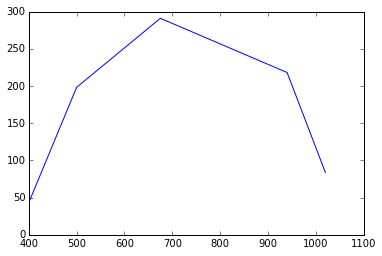

In [340]:
plt.plot(wavelengths,spectrometer)

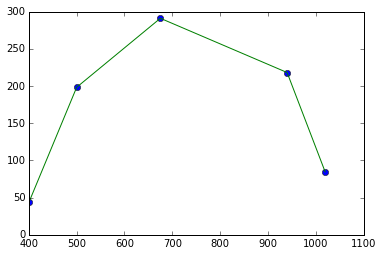

In [341]:
from scipy import interpolate

x = wavelengths
y = spectrometer

f = interpolate.interp1d(x, y)
wav_new = np.arange(400,1020, 0.5) #300 nm to 1180 nm with 0.5 nm spacing
spec_new = f(wav_new)   #recreate AM1.5 with 0.5 nm spacing

plt.plot(x, y, 'o', wav_new, spec_new, '-')
plt.show()

In [342]:
sum(wav_new*spec_new)*.5/1240/100

780.22615203649048

##Web scraping for pvoutput.org

In [343]:
import mechanize
import cookielib
import os
PVOUTPUT_USERNAME = os.environ['PVOUTPUT_USERNAME']
PVOUTPUT_PASSWORD = os.environ['PVOUTPUT_PASSWORD']
PVOUTPUT_API = os.environ['PVOUTPUT_API']

#web scraping
cj = cookielib.CookieJar() #saves the cookie?
br = mechanize.Browser() #instansiates a browser
br.set_handle_robots(False) #I am not a robot...
br.set_cookiejar(cj) #use cookie?
br.open("http://pvoutput.org/") #open login page
br.select_form(nr=0) #select login form
br.form['login'] = PVOUTPUT_USERNAME #login using saved env vars
br.form['password'] = PVOUTPUT_PASSWORD #login using saved env vars
br.submit() #press enter
#print br.response().read() #see if it worked
br.open("http://pvoutput.org/intraday.jsp?id=5446&sid=5473&dt=20150701") #open desired page
html = br.response().read() #read desired page
df_html = pd.read_html(html)[0]

#cleaning the data
df_html.columns = pd.MultiIndex.from_arrays(df_html[df_html.index==1].values)
df_html.drop(df_html.index[[0,1]],inplace=True)
df_html['Power'] = df_html['Power'].str.replace(',','')
df_html['Power'] = df_html['Power'].map(lambda x: x.rstrip('W'))

def make_a_no(x):                  
    try:
        return int(x)
    except:
        x = 0 
        return x
    
df_html['Power'] = df_html['Power'].map(make_a_no)
df_html['datetime'] = pd.to_datetime(df_html['Date'] + ' ' + df_html['Time'], unit='h')
df_html.set_index(['datetime'],inplace=True)
df_html.head()

,Date,Time,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used,nan
datetime,,,,,,,,,,,,
2015-07-01 23:55:00,2015-07-01,23:55,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.801kWh,"1,921W",NaN
2015-07-01 23:50:00,2015-07-01,23:50,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.641kWh,"2,215W",NaN
2015-07-01 23:45:00,2015-07-01,23:45,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.456kWh,"2,230W",NaN
2015-07-01 23:40:00,2015-07-01,23:40,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.271kWh,"2,237W",NaN
2015-07-01 23:35:00,2015-07-01,23:35,61.260kWh,4.317kWh/kW,0,0W,0.000kW/kW,-,-,66.084kWh,"2,230W",NaN


##Making a simple linear model

In [344]:
powers = df_html.resample('H', how='mean')['Power'].values

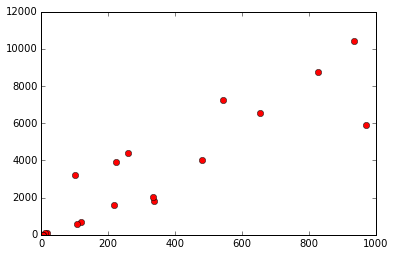

In [345]:
plt.plot(intensities,powers,'ro') #output powers vs. intensities

In [346]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(powers,intensities)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     231.0
Date:                Wed, 05 Aug 2015   Prob (F-statistic):           1.74e-13
Time:                        15:15:41   Log-Likelihood:                -204.38
No. Observations:                  24   AIC:                             410.8
Df Residuals:                      23   BIC:                             411.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             9.5328      0.627     15.199      0.0

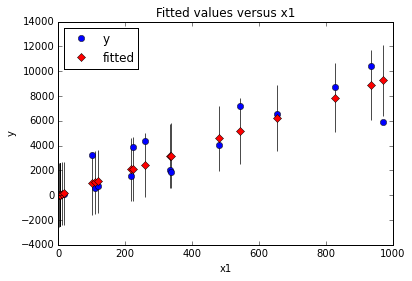

In [347]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)

##Another day: the next day (July 2nd)

In [348]:
col_0702_df = pd.read_csv('data/colorado20150702.txt')
def to_str(x):
    if x < 10:
        return '0' + x.astype(str)
    else:
        return x.astype(str)
        
col_0702_df['datetime'] = pd.to_datetime(col_0702_df['DATE (MM/DD/YYYY)']+' '+col_0702_df['HOUR-MST'].map(to_str))
intensities = np.insert(col_0702_df['Avg Global PSP (vent/cor) [W/m^2]'].values,0,0)

### copy from above

In [349]:
import mechanize
import cookielib
import os
PVOUTPUT_USERNAME = os.environ['PVOUTPUT_USERNAME']
PVOUTPUT_PASSWORD = os.environ['PVOUTPUT_PASSWORD']
PVOUTPUT_API = os.environ['PVOUTPUT_API']

#web scraping
cj = cookielib.CookieJar() #saves the cookie?
br = mechanize.Browser() #instansiates a browser
br.set_handle_robots(False) #I am not a robot...
br.set_cookiejar(cj) #use cookie?
br.open("http://pvoutput.org/") #open login page
br.select_form(nr=0) #select login form
br.form['login'] = PVOUTPUT_USERNAME #login using saved env vars
br.form['password'] = PVOUTPUT_PASSWORD #login using saved env vars
br.submit() #press enter
#print br.response().read() #see if it worked
br.open("http://pvoutput.org/intraday.jsp?id=5446&sid=5473&dt=20150702") #open desired page
html = br.response().read() #read desired page
df_html = pd.read_html(html)[0]

#cleaning the data
df_html.columns = pd.MultiIndex.from_arrays(df_html[df_html.index==1].values)
df_html.drop(df_html.index[[0,1]],inplace=True)
df_html['Power'] = df_html['Power'].str.replace(',','')
df_html['Power'] = df_html['Power'].map(lambda x: x.rstrip('W'))

def make_a_no(x):                  
    try:
        return int(x)
    except:
        x = 0 
        return x
    
df_html['Power'] = df_html['Power'].map(make_a_no)
df_html['datetime'] = pd.to_datetime(df_html['Date'] + ' ' + df_html['Time'], unit='h')
df_html.set_index(['datetime'],inplace=True)
df_html.head()

,Date,Time,Energy,Efficiency,Power,Average,Normalised,Temperature,Voltage,Energy Used,Power Used,nan
datetime,,,,,,,,,,,,
2015-07-02 23:55:00,2015-07-02,23:55,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.868kWh,"1,789W",NaN
2015-07-02 23:50:00,2015-07-02,23:50,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.719kWh,"1,881W",NaN
2015-07-02 23:45:00,2015-07-02,23:45,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.562kWh,"2,032W",NaN
2015-07-02 23:40:00,2015-07-02,23:40,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.393kWh,"2,031W",NaN
2015-07-02 23:35:00,2015-07-02,23:35,74.866kWh,5.276kWh/kW,0,0W,0.000kW/kW,-,-,53.224kWh,"2,057W",NaN


###use yesterdays model to predict today

In [350]:
powers = df_html.resample('H', how='mean')['Power'].values

In [351]:
powers_pred = res.predict(intensities)

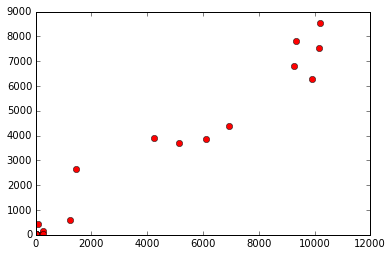

In [352]:
plt.plot(powers,powers_pred, 'ro')

In [353]:
mod2 = sm.OLS(powers_pred,powers)
res2 = mod.fit()
print res2.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     231.0
Date:                Wed, 05 Aug 2015   Prob (F-statistic):           1.74e-13
Time:                        15:15:48   Log-Likelihood:                -204.38
No. Observations:                  24   AIC:                             410.8
Df Residuals:                      23   BIC:                             411.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             9.5328      0.627     15.199      0.0

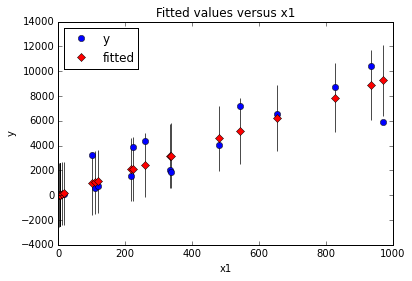

In [354]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res2, 0, ax=ax)

##Now a satellite? (or what are we gunna do?)

type of data:  NETCDF3_CLASSIC
variables in data:  [u'version', u'sensorID', u'imageDate', u'imageTime', u'startLine', u'startElem', u'time', u'dataWidth', u'lineRes', u'elemRes', u'prefixSize', u'crDate', u'crTime', u'bands', u'auditTrail', u'data', u'lat', u'lon']
latitude of one point;  41.0006


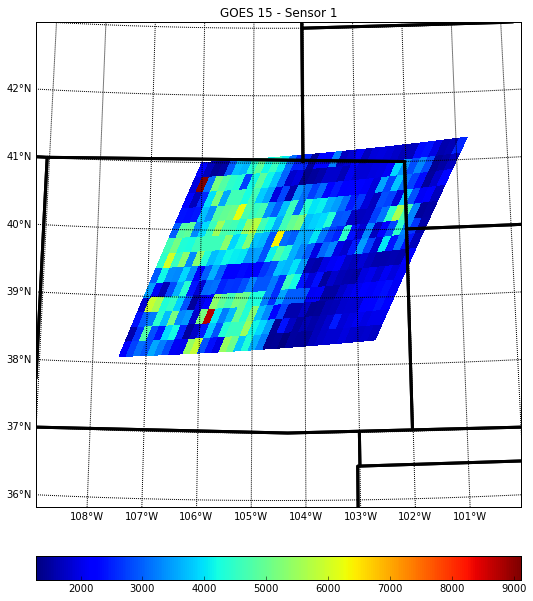

In [355]:
import netCDF4
from netCDF4 import Dataset
rootgrp = Dataset("data/satellite/colorado/20150701/goes15.2015.182.010019.BAND_01.nc", "a", format="NETCDF4")

print "type of data: ", rootgrp.data_model #netcdf3_classic, not netcdf4
myvars = []
for var in rootgrp.variables: #list of variables
    myvars.append(var)
print "variables in data: ", myvars
print "latitude of one point; ", rootgrp.variables['lat'][0][0] #verify that one latitude is where we expect

lons = rootgrp.variables['lon'][:]
lats = rootgrp.variables['lat'][:]
data = rootgrp.variables['data'][:] #data is sensor data
rootgrp.close() #need to close before you can open again

from mpl_toolkits.basemap import Basemap  #map stuff
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Get some parameters for the Stereographic Projection
m = Basemap(width=800000,height=800000,
            resolution='l',projection='stere',\
            lat_ts=40,lat_0=39.5,lon_0=-104.5)

xi, yi = m(lons, lats) #map onton x and y for plotting
plt.figure(figsize=(10,10)) # Plot Data
cs = m.pcolor(xi,yi,np.squeeze(data)) #data is 1 x 14 x 36, squeeze makes it 14 x 36

m.drawparallels(np.arange(-80., 81., 1.), labels=[1,0,0,0], fontsize=10) # Add Grid Lines
m.drawmeridians(np.arange(-180., 181., 1.), labels=[0,0,0,1], fontsize=10) # Add Grid Lines
m.drawstates(linewidth=3) # Add state boundaries

cbar = m.colorbar(cs, location='bottom', pad="10%") # Add Colorbar
plt.title('GOES 15 - Sensor 1') # Add Title
plt.show()

In [356]:
print data[0].shape
print data[0][0].shape
print data.mean()

(14, 36)
(36,)
3001.71


In [357]:
import os
data_files = os.listdir('data/satellite/colorado/20150701')

list_of_files = []
list_of_files_details = []
for myfile in data_files:
    if myfile[-2:] == 'nc':
        list_of_files.append(myfile)
        list_of_files_details.append(myfile.split('.'))
list_of_files_details

[['goes15', '2015', '182', '003021', 'BAND_01', 'nc'],
 ['goes15', '2015', '182', '003021', 'BAND_02', 'nc'],
 ['goes15', '2015', '182', '003021', 'BAND_03', 'nc'],
 ['goes15', '2015', '182', '003021', 'BAND_04', 'nc'],
 ['goes15', '2015', '182', '003021', 'BAND_06', 'nc'],
 ['goes15', '2015', '182', '010019', 'BAND_01', 'nc'],
 ['goes15', '2015', '182', '010019', 'BAND_02', 'nc'],
 ['goes15', '2015', '182', '010019', 'BAND_03', 'nc'],
 ['goes15', '2015', '182', '010019', 'BAND_04', 'nc'],
 ['goes15', '2015', '182', '010019', 'BAND_06', 'nc'],
 ['goes15', '2015', '182', '013020', 'BAND_01', 'nc'],
 ['goes15', '2015', '182', '013020', 'BAND_02', 'nc'],
 ['goes15', '2015', '182', '013020', 'BAND_03', 'nc'],
 ['goes15', '2015', '182', '013020', 'BAND_04', 'nc'],
 ['goes15', '2015', '182', '013020', 'BAND_06', 'nc'],
 ['goes15', '2015', '182', '020019', 'BAND_01', 'nc'],
 ['goes15', '2015', '182', '020019', 'BAND_02', 'nc'],
 ['goes15', '2015', '182', '020019', 'BAND_03', 'nc'],
 ['goes15'

In [358]:
import datetime
list_of_dates = []
for i,_ in enumerate(list_of_files_details):
    mytime = list_of_files_details[i][1]+" "+list_of_files_details[i][2]+" "+list_of_files_details[i][3]
    mydatetime = datetime.datetime.strptime(mytime, '%Y %j %H%M%S')
    list_of_dates.append(mydatetime)

In [359]:
channel_list = ['BAND_01', 'BAND_02', 'BAND_03', 'BAND_04', 'BAND_06']
index = np.unique(list_of_dates)
mydata_df = pd.DataFrame(index=index,columns=channel_list)
mydata_df.fillna(0).head()

,BAND_01,BAND_02,BAND_03,BAND_04,BAND_06
2015-07-01 00:30:21,0,0,0,0,0
2015-07-01 01:00:19,0,0,0,0,0
2015-07-01 01:30:20,0,0,0,0,0
2015-07-01 02:00:19,0,0,0,0,0
2015-07-01 02:30:19,0,0,0,0,0


In [360]:
for i , myfile in enumerate(list_of_files):
    rootgrp = Dataset("data/satellite/colorado/20150701/" + myfile, "a", format="NETCDF4")
    lons = rootgrp.variables['lon'][:]
    lats = rootgrp.variables['lat'][:]
    data = rootgrp.variables['data'][:] #data is sensor data
    rootgrp.close() #need to close before you can open again
    
    mytime = list_of_files_details[i][1]+" "+list_of_files_details[i][2]+" "+list_of_files_details[i][3]
    mydatetime = datetime.datetime.strptime(mytime, '%Y %j %H%M%S')
    
    mydata_df.loc[mydatetime, list_of_files_details[i][4]] = data.mean()

In [369]:
mydata_df = mydata_df.convert_objects(convert_numeric=True)
mydata_df = mydata_df.resample('H', how='mean')
mydata_df.head()

,BAND_01,BAND_02,BAND_03,BAND_04,BAND_06
2015-07-01 00:00:00,3688.063477,5766.603027,5456.698242,10962.159180,12312.253906
2015-07-01 01:00:00,2616.984131,4904.635010,5238.285645,9897.301758,11597.555664
2015-07-01 02:00:00,1218.698395,3891.936523,4831.047607,8473.460449,10540.889160
2015-07-01 03:00:00,931.555542,3422.095215,4476.507812,7416.317383,9665.904297
2015-07-01 04:00:00,929.777771,3171.904785,4401.714355,6903.301758,9335.111328


##Try a model to fit the channel means

In [370]:
X = mydata_df.values

In [371]:
import statsmodels.api as sm

# Fit and summarize OLS model
mod = sm.OLS(intensities,X)
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     18.55
Date:                Wed, 05 Aug 2015   Prob (F-statistic):           1.01e-06
Time:                        15:21:04   Log-Likelihood:                -156.53
No. Observations:                  24   AIC:                             323.1
Df Residuals:                      19   BIC:                             329.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0221      0.046      0.482      0.6

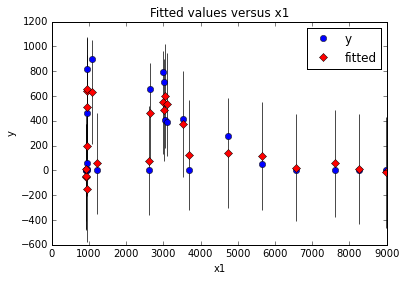

In [364]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, 0, ax=ax)

##Now using this, can we make virtual sensors for the next day?

##Try WunderGround API - (it doesn't have historical data)

In [1]:
import os
WUNDERGROUND_API = os.environ['WUNDERGROUND_API']

##Automate GOES satellite downloads

In [4]:
from noaaclass import noaaclass
import os

In [5]:
username = os.environ['NOAA_USERNAME']
password = os.environ['NOAA_PASSWORD']
noaa = noaaclass.connect(username, password)

In [6]:
print noaa.subscribe.products()

['gvar_img']


In [22]:
from noaaclass import noaaclass
noaa = noaaclass.connect(username, password)
data = noaa.subscribe.gvar_img.get()

In [26]:
data = noaa.request.gvar_img.get(async=True, hours = 6, append_files=True)

In [31]:
data[0]['files']

{'ftp': ['ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.meta',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_03.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_04.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_01.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_02.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.021520.BAND_06.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_01.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.meta',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_02.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_06.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_03.nc',
  'ftp://ftp.class.ngdc.noaa.gov/1979635905/001/goes15.2015.182.024520.BAND_04.nc

In [16]:
from datetime import datetime
data3 = [
    {
        'id': '+',
        'enabled': True,
        'name': '[auto] sample1',
        'north': 41.00,
        'south': 38.00,
        'west': -106.00,
        'east': -103.00,
        'coverage': ['NH'],
        'schedule': ['R'],
        'satellite': ['G15'],
        'channel': [1, 2, 3, 4, 5, 6],
        'format': 'NetCDF',
        'start': datetime(2014, 7, 2, 0, 0, 0),
        'end': datetime(2014, 7, 2, 23, 59, 59)
    }
]

In [17]:
from noaaclass import noaaclass
noaa = noaaclass.connect(username, password)

In [18]:
data3 = noaa.request.gvar_img.set(data2, async=True)

In [19]:
data3

[{'channel': [1],
  'datetime': datetime.datetime(2015, 8, 5, 2, 55, 33),
  'east': -103.0,
  'files': {'ftp': [], 'http': []},
  'format': u'NetCDF',
  'id': u'1982768383',
  'last_activity': datetime.datetime(2015, 8, 5, 2, 59, 6),
  'north': 41.0,
  'old': False,
  'size': 46740,
  'south': 38.0,
  'status': u'in progress',
  'west': -106.0}]